# <img src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Basketball.png" width="60"> NBA-joukkueiden perinteiset tilastot (kausi 2023–24 opetusdataan ja 2024–25 testaukseen)

Dataseteissä on joukkueiden per-ottelu -tilastot kaikilta NBA-joukkueilta kyseisillä kausilla.  
Jokainen rivi edustaa yhtä joukkuetta ja sisältää sekä suorituskykymittarit että sarjataulukkoon perustuvat ranking-arvot kutakin tilastoa varten.

**Tämä analyysi keskittyy ainoastaan varsinaisiin NBA-joukkueisiin (30 joukkuetta)**

---

## Datasetin yleiskuva

| Ominaisuus | Kuvaus |
|-----------|-------------|
| **Havaintoyksiköt (rivit)** | 30 joukkuetta |
| **Sarakkeet (ominaisuudet)** | 54 |
| **Tietotyypit** | `int64`, `float64`, `object` |
| **Lähde** | [NBA Stats API - LeagueDashTeamStats](https://stats.nba.com/stats/leaguedashteamstats) |

---

## Sarakkeiden kuvaukset

### Perustiedot joukkueesta
| Sarake | Kuvaus | Tyyppi |
|--------|--------|-------|
| `TEAM_ID` | Jokaiselle joukkueelle yksilöllinen numeerinen tunniste. | `int64` |
| `TEAM_NAME` | Virallinen joukkueen nimi (esim. *Boston Celtics*, *Golden State Warriors*). | `object` |

---

### Joukkueen suorituskyky
| Sarake | Kuvaus | Tyyppi |
|--------|--------|-------|
| `GP` | Pelatut ottelut. | `int64` |
| `W` | Voitot. | `int64` |
| `L` | Häviöt. | `int64` |
| `W_PCT` | Voittoprosentti (`W / GP`). | `float64` |
| `MIN` | Keskimäärin pelatut minuutit per ottelu. | `float64` |

---

### Heittotilastot
| Sarake | Kuvaus | Tyyppi |
|--------|--------|-------|
| `FGM` | Kenttäheitot tehtynä per ottelu. | `float64` |
| `FGA` | Kenttäheitot yrityksinä per ottelu. | `float64` |
| `FG_PCT` | Kenttäheittoprosentti. | `float64` |
| `FG3M` | Kolmen pisteen heitot tehtynä per ottelu. | `float64` |
| `FG3A` | Kolmen pisteen heitot yrityksinä per ottelu. | `float64` |
| `FG3_PCT` | Kolmen pisteen heittoprosentti. | `float64` |
| `FTM` | Vapaapotkut tehtynä per ottelu. | `float64` |
| `FTA` | Vapaapotkut yrityksinä per ottelu. | `float64` |
| `FT_PCT` | Vapaapotkumaali% | `float64` |

---

### Levypallot ja syötöt
| Sarake | Kuvaus | Tyyppi |
|--------|--------|-------|
| `OREB` | Hyökkäyslevypallot per ottelu. | `float64` |
| `DREB` | Puolustuslevypallot per ottelu. | `float64` |
| `REB` | Levypallot yhteensä per ottelu. | `float64` |
| `AST` | Syötöt per ottelu. | `float64` |

---

### Puolustus ja pallonhallinta
| Sarake | Kuvaus | Tyyppi |
|--------|--------|-------|
| `TOV` | Menetykset per ottelu. | `float64` |
| `STL` | Riistot per ottelu. | `float64` |
| `BLK` | Torjunnat per ottelu. | `float64` |
| `BLKA` | Torjutut heitot (kuinka monta kertaa joukkueen heitto torjuttiin). | `float64` |
| `PF` | Henkilökohtaiset virheet per ottelu. | `float64` |
| `PFD` | Vastaanotetut virheet per ottelu. | `float64` |
| `PTS` | Tehdyt pisteet per ottelu. | `float64` |
| `PLUS_MINUS` | Keskimääräinen pistetulosero (joukkueen pisteet miinus vastustajan pisteet). | `float64` |

---

### Ranking-mittarit
Jokaiselle päätilastolle on vastaava **sarjaranking**-sarake (1 = paras).  
Esim. `FG3A_RANK = 1` tarkoittaa, että joukkue yritti eniten kolmen pisteen heittoja liigassa.

| Sarakemalli | Kuvaus | Esimerkki |
|-------------|--------|-----------|
| `*_RANK` | Joukkueen sijoitus vastaavassa tilastossa. | `PTS_RANK`, `REB_RANK`, `FG3A_RANK` |

---

## Huomioita
- Kaikki tilastot ovat **per-ottelu keskiarvoja**, ellei toisin mainita.  
- Rankingit ovat suhteessa kaikkiin datasetin joukkueisiin.  
- Dataset voi sisältää yli 30 riviä (esim. historialliset tai yhdistetyt joukkueiden tiedot).  
- Data on haettu suoraan NBA:n virallisesta Stats API:sta.


!pip install nba_api

In [38]:
from nba_api.stats.endpoints import leaguedashteamstats
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Hae 2023–24 kauden "traditional team stats". "league_id_nullable='00'" hakee vain NBA-joukkueet. 
data = leaguedashteamstats.LeagueDashTeamStats(
    season='2023-24',
    season_type_all_star='Regular Season',
    per_mode_detailed='PerGame',  
    league_id_nullable='00'   
)

# Testidataksi 2024–25 tilastot
test_data = leaguedashteamstats.LeagueDashTeamStats(
    season='2024-25',
    season_type_all_star='Regular Season',
    per_mode_detailed='PerGame',  
    league_id_nullable='00'   
)

# Toiseksi testidataksi 2022–23 tilastot
test_data2 = leaguedashteamstats.LeagueDashTeamStats(
    season='2022-23',
    season_type_all_star='Regular Season',
    per_mode_detailed='PerGame',  
    league_id_nullable='00'   
)

df = data.get_data_frames()[0]
test_df = test_data.get_data_frames()[0]
test_df2 = test_data2.get_data_frames()[0]

# tulostetaan ensimmäiset rivit
print(df.head())
print(test_df.head())
print(test_df2.head())

# tallennetaan CSV-tiedostoiksi
df.to_csv("nba_team_stats_2023_24.csv", index=False)
test_df.to_csv("nba_team_stats_2024_25.csv", index=False)
test_df2.to_csv("nba_team_stats_2022_23.csv", index=False)

      TEAM_ID          TEAM_NAME  GP   W   L  W_PCT   MIN   FGM   FGA  FG_PCT  \
0  1610612737      Atlanta Hawks  82  36  46  0.439  48.4  43.0  92.5   0.465   
1  1610612738     Boston Celtics  82  64  18  0.780  48.4  43.9  90.2   0.487   
2  1610612751      Brooklyn Nets  82  32  50  0.390  48.3  40.7  89.1   0.456   
3  1610612766  Charlotte Hornets  82  21  61  0.256  48.1  40.0  87.0   0.460   
4  1610612741      Chicago Bulls  82  39  43  0.476  48.7  42.0  89.5   0.470   

   ...  REB_RANK  AST_RANK  TOV_RANK  STL_RANK  BLK_RANK  BLKA_RANK  PF_RANK  \
0  ...         6        16        16        16        26         22       15   
1  ...         2        14         1        27         1          1        2   
2  ...        11        20        12        28        12         16       13   
3  ...        30        26        18        25        25         13        7   
4  ...        14        23         3         9        18         14       17   

   PFD_RANK  PTS_RANK  PLUS_MINU

In [39]:
# Varmistetaan, että opetusdata ja testidatat poikkeavat toisistaan
similarity = (df == test_df).stack().mean()
print(f"Opetus- ja testidatan samanlaisuusprosentti kauden 2024 - 2025 testiaineistolla: {similarity*100:.2f}%")

similarity = (df == test_df2).stack().mean()
print(f"Opetus- ja testidatan samanlaisuusprosentti kauden 2022 - 2023 testiaineistolla: {similarity*100:.2f}%")

Opetus- ja testidatan samanlaisuusprosentti kauden 2024 - 2025 testiaineistolla: 12.35%
Opetus- ja testidatan samanlaisuusprosentti kauden 2022 - 2023 testiaineistolla: 11.60%


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 54 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TEAM_ID          30 non-null     int64  
 1   TEAM_NAME        30 non-null     object 
 2   GP               30 non-null     int64  
 3   W                30 non-null     int64  
 4   L                30 non-null     int64  
 5   W_PCT            30 non-null     float64
 6   MIN              30 non-null     float64
 7   FGM              30 non-null     float64
 8   FGA              30 non-null     float64
 9   FG_PCT           30 non-null     float64
 10  FG3M             30 non-null     float64
 11  FG3A             30 non-null     float64
 12  FG3_PCT          30 non-null     float64
 13  FTM              30 non-null     float64
 14  FTA              30 non-null     float64
 15  FT_PCT           30 non-null     float64
 16  OREB             30 non-null     float64
 17  DREB             3

In [3]:
df.describe()

,TEAM_ID,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
count,3.000000e+01,30.0,30.000000,30.000000,30.00000,30.00000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.610613e+09,82.0,41.000000,41.000000,0.50000,48.27000,42.176667,88.903333,0.474300,12.840000,...,15.466667,15.500000,15.400000,15.433333,15.400000,15.466667,15.500000,15.466667,15.500000,15.466667
std,8.803408e+00,0.0,13.411266,13.411266,0.16355,0.14657,1.717995,2.073558,0.016912,1.217572,...,8.850222,8.803408,8.814565,8.842231,8.892461,8.752274,8.803408,8.760150,8.803408,8.826814
min,1.610613e+09,82.0,14.000000,18.000000,0.17100,48.10000,38.400000,84.900000,0.435000,11.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.610613e+09,82.0,31.250000,33.000000,0.38100,48.12500,41.300000,87.425000,0.464250,12.100000,...,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000,8.250000
50%,1.610613e+09,82.0,46.500000,35.500000,0.56700,48.30000,42.150000,89.200000,0.473500,12.600000,...,15.500000,15.500000,15.500000,15.500000,15.000000,15.500000,15.500000,15.500000,15.500000,15.500000
75%,1.610613e+09,82.0,49.000000,50.750000,0.59800,48.40000,43.100000,90.125000,0.486750,13.300000,...,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000,22.750000
max,1.610613e+09,82.0,64.000000,68.000000,0.78000,48.70000,47.000000,92.700000,0.507000,16.500000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [4]:
df["TEAM_NAME"]

0              Atlanta Hawks
1             Boston Celtics
2              Brooklyn Nets
3          Charlotte Hornets
4              Chicago Bulls
5        Cleveland Cavaliers
6           Dallas Mavericks
7             Denver Nuggets
8            Detroit Pistons
9      Golden State Warriors
10           Houston Rockets
11            Indiana Pacers
12               LA Clippers
13        Los Angeles Lakers
14         Memphis Grizzlies
15                Miami Heat
16           Milwaukee Bucks
17    Minnesota Timberwolves
18      New Orleans Pelicans
19           New York Knicks
20     Oklahoma City Thunder
21             Orlando Magic
22        Philadelphia 76ers
23              Phoenix Suns
24    Portland Trail Blazers
25          Sacramento Kings
26         San Antonio Spurs
27           Toronto Raptors
28                 Utah Jazz
29        Washington Wizards
Name: TEAM_NAME, dtype: object

In [5]:
test_df["TEAM_NAME"]

0              Atlanta Hawks
1             Boston Celtics
2              Brooklyn Nets
3          Charlotte Hornets
4              Chicago Bulls
5        Cleveland Cavaliers
6           Dallas Mavericks
7             Denver Nuggets
8            Detroit Pistons
9      Golden State Warriors
10           Houston Rockets
11            Indiana Pacers
12               LA Clippers
13        Los Angeles Lakers
14         Memphis Grizzlies
15                Miami Heat
16           Milwaukee Bucks
17    Minnesota Timberwolves
18      New Orleans Pelicans
19           New York Knicks
20     Oklahoma City Thunder
21             Orlando Magic
22        Philadelphia 76ers
23              Phoenix Suns
24    Portland Trail Blazers
25          Sacramento Kings
26         San Antonio Spurs
27           Toronto Raptors
28                 Utah Jazz
29        Washington Wizards
Name: TEAM_NAME, dtype: object

In [40]:
# Tarkastetaan, että opetus- ja testidatan joukkueet vastaavat toisiaan
from itertools import zip_longest

for a, b, c in zip_longest(df["TEAM_NAME"], test_df["TEAM_NAME"], test_df2["TEAM_NAME"], fillvalue="---"):
    print(f"{a:25} | {b} | {b}")

Atlanta Hawks             | Atlanta Hawks
Boston Celtics            | Boston Celtics
Brooklyn Nets             | Brooklyn Nets
Charlotte Hornets         | Charlotte Hornets
Chicago Bulls             | Chicago Bulls
Cleveland Cavaliers       | Cleveland Cavaliers
Dallas Mavericks          | Dallas Mavericks
Denver Nuggets            | Denver Nuggets
Detroit Pistons           | Detroit Pistons
Golden State Warriors     | Golden State Warriors
Houston Rockets           | Houston Rockets
Indiana Pacers            | Indiana Pacers
LA Clippers               | LA Clippers
Los Angeles Lakers        | Los Angeles Lakers
Memphis Grizzlies         | Memphis Grizzlies
Miami Heat                | Miami Heat
Milwaukee Bucks           | Milwaukee Bucks
Minnesota Timberwolves    | Minnesota Timberwolves
New Orleans Pelicans      | New Orleans Pelicans
New York Knicks           | New York Knicks
Oklahoma City Thunder     | Oklahoma City Thunder
Orlando Magic             | Orlando Magic
Philadelphia 76e

array([[<Axes: title={'center': 'TEAM_ID'}>,
        <Axes: title={'center': 'GP'}>, <Axes: title={'center': 'W'}>,
        <Axes: title={'center': 'L'}>, <Axes: title={'center': 'W_PCT'}>,
        <Axes: title={'center': 'MIN'}>, <Axes: title={'center': 'FGM'}>],
       [<Axes: title={'center': 'FGA'}>,
        <Axes: title={'center': 'FG_PCT'}>,
        <Axes: title={'center': 'FG3M'}>,
        <Axes: title={'center': 'FG3A'}>,
        <Axes: title={'center': 'FG3_PCT'}>,
        <Axes: title={'center': 'FTM'}>, <Axes: title={'center': 'FTA'}>],
       [<Axes: title={'center': 'FT_PCT'}>,
        <Axes: title={'center': 'OREB'}>,
        <Axes: title={'center': 'DREB'}>,
        <Axes: title={'center': 'REB'}>, <Axes: title={'center': 'AST'}>,
        <Axes: title={'center': 'TOV'}>, <Axes: title={'center': 'STL'}>],
       [<Axes: title={'center': 'BLK'}>,
        <Axes: title={'center': 'BLKA'}>, <Axes: title={'center': 'PF'}>,
        <Axes: title={'center': 'PFD'}>, <Axes: title=

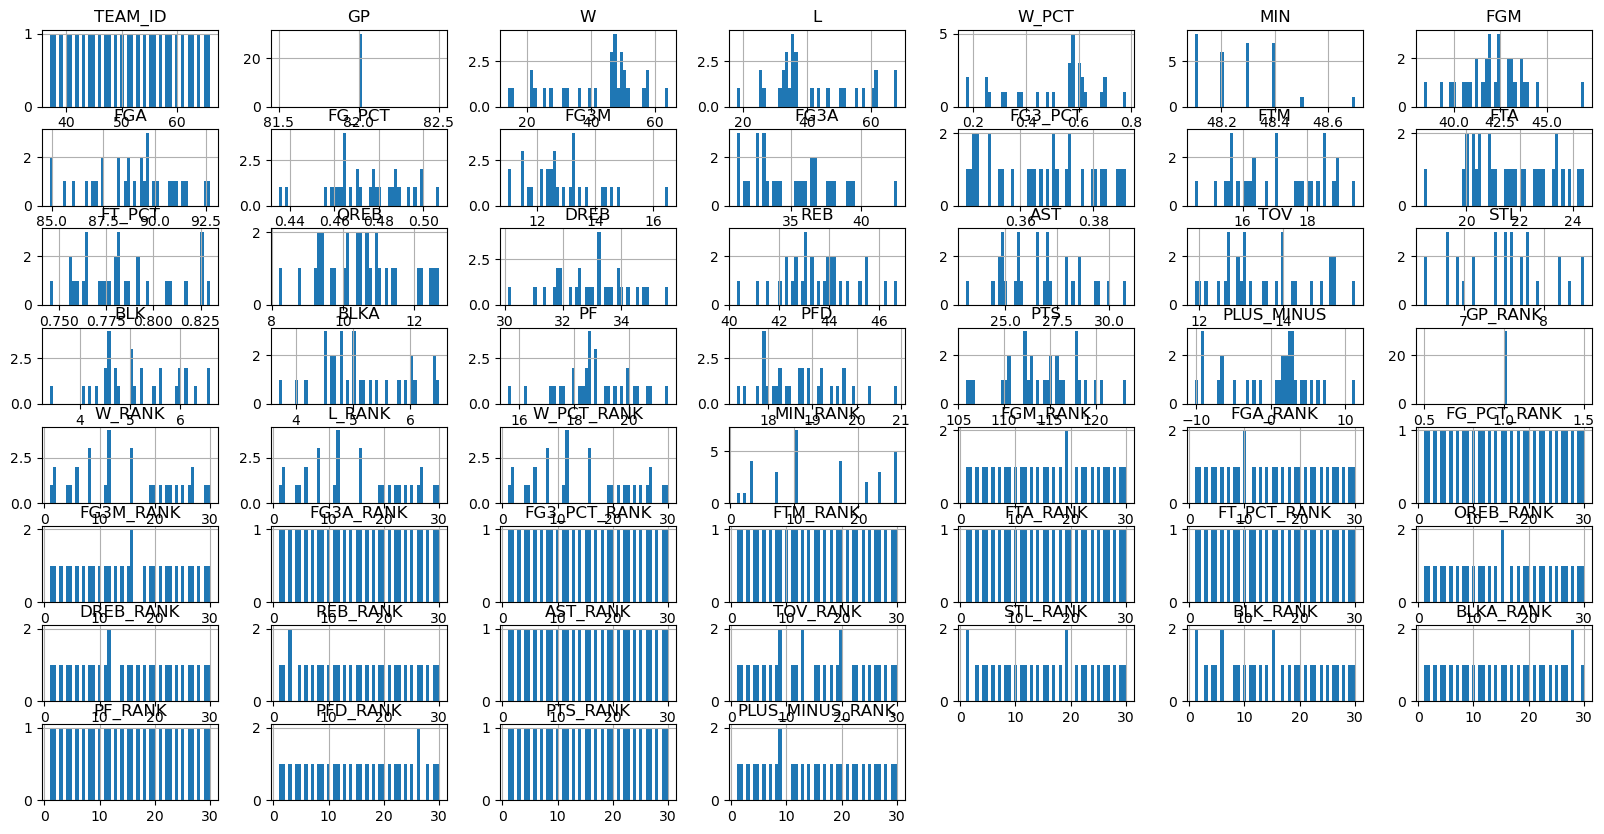

In [7]:
df.hist(bins=50, figsize=(20, 10))

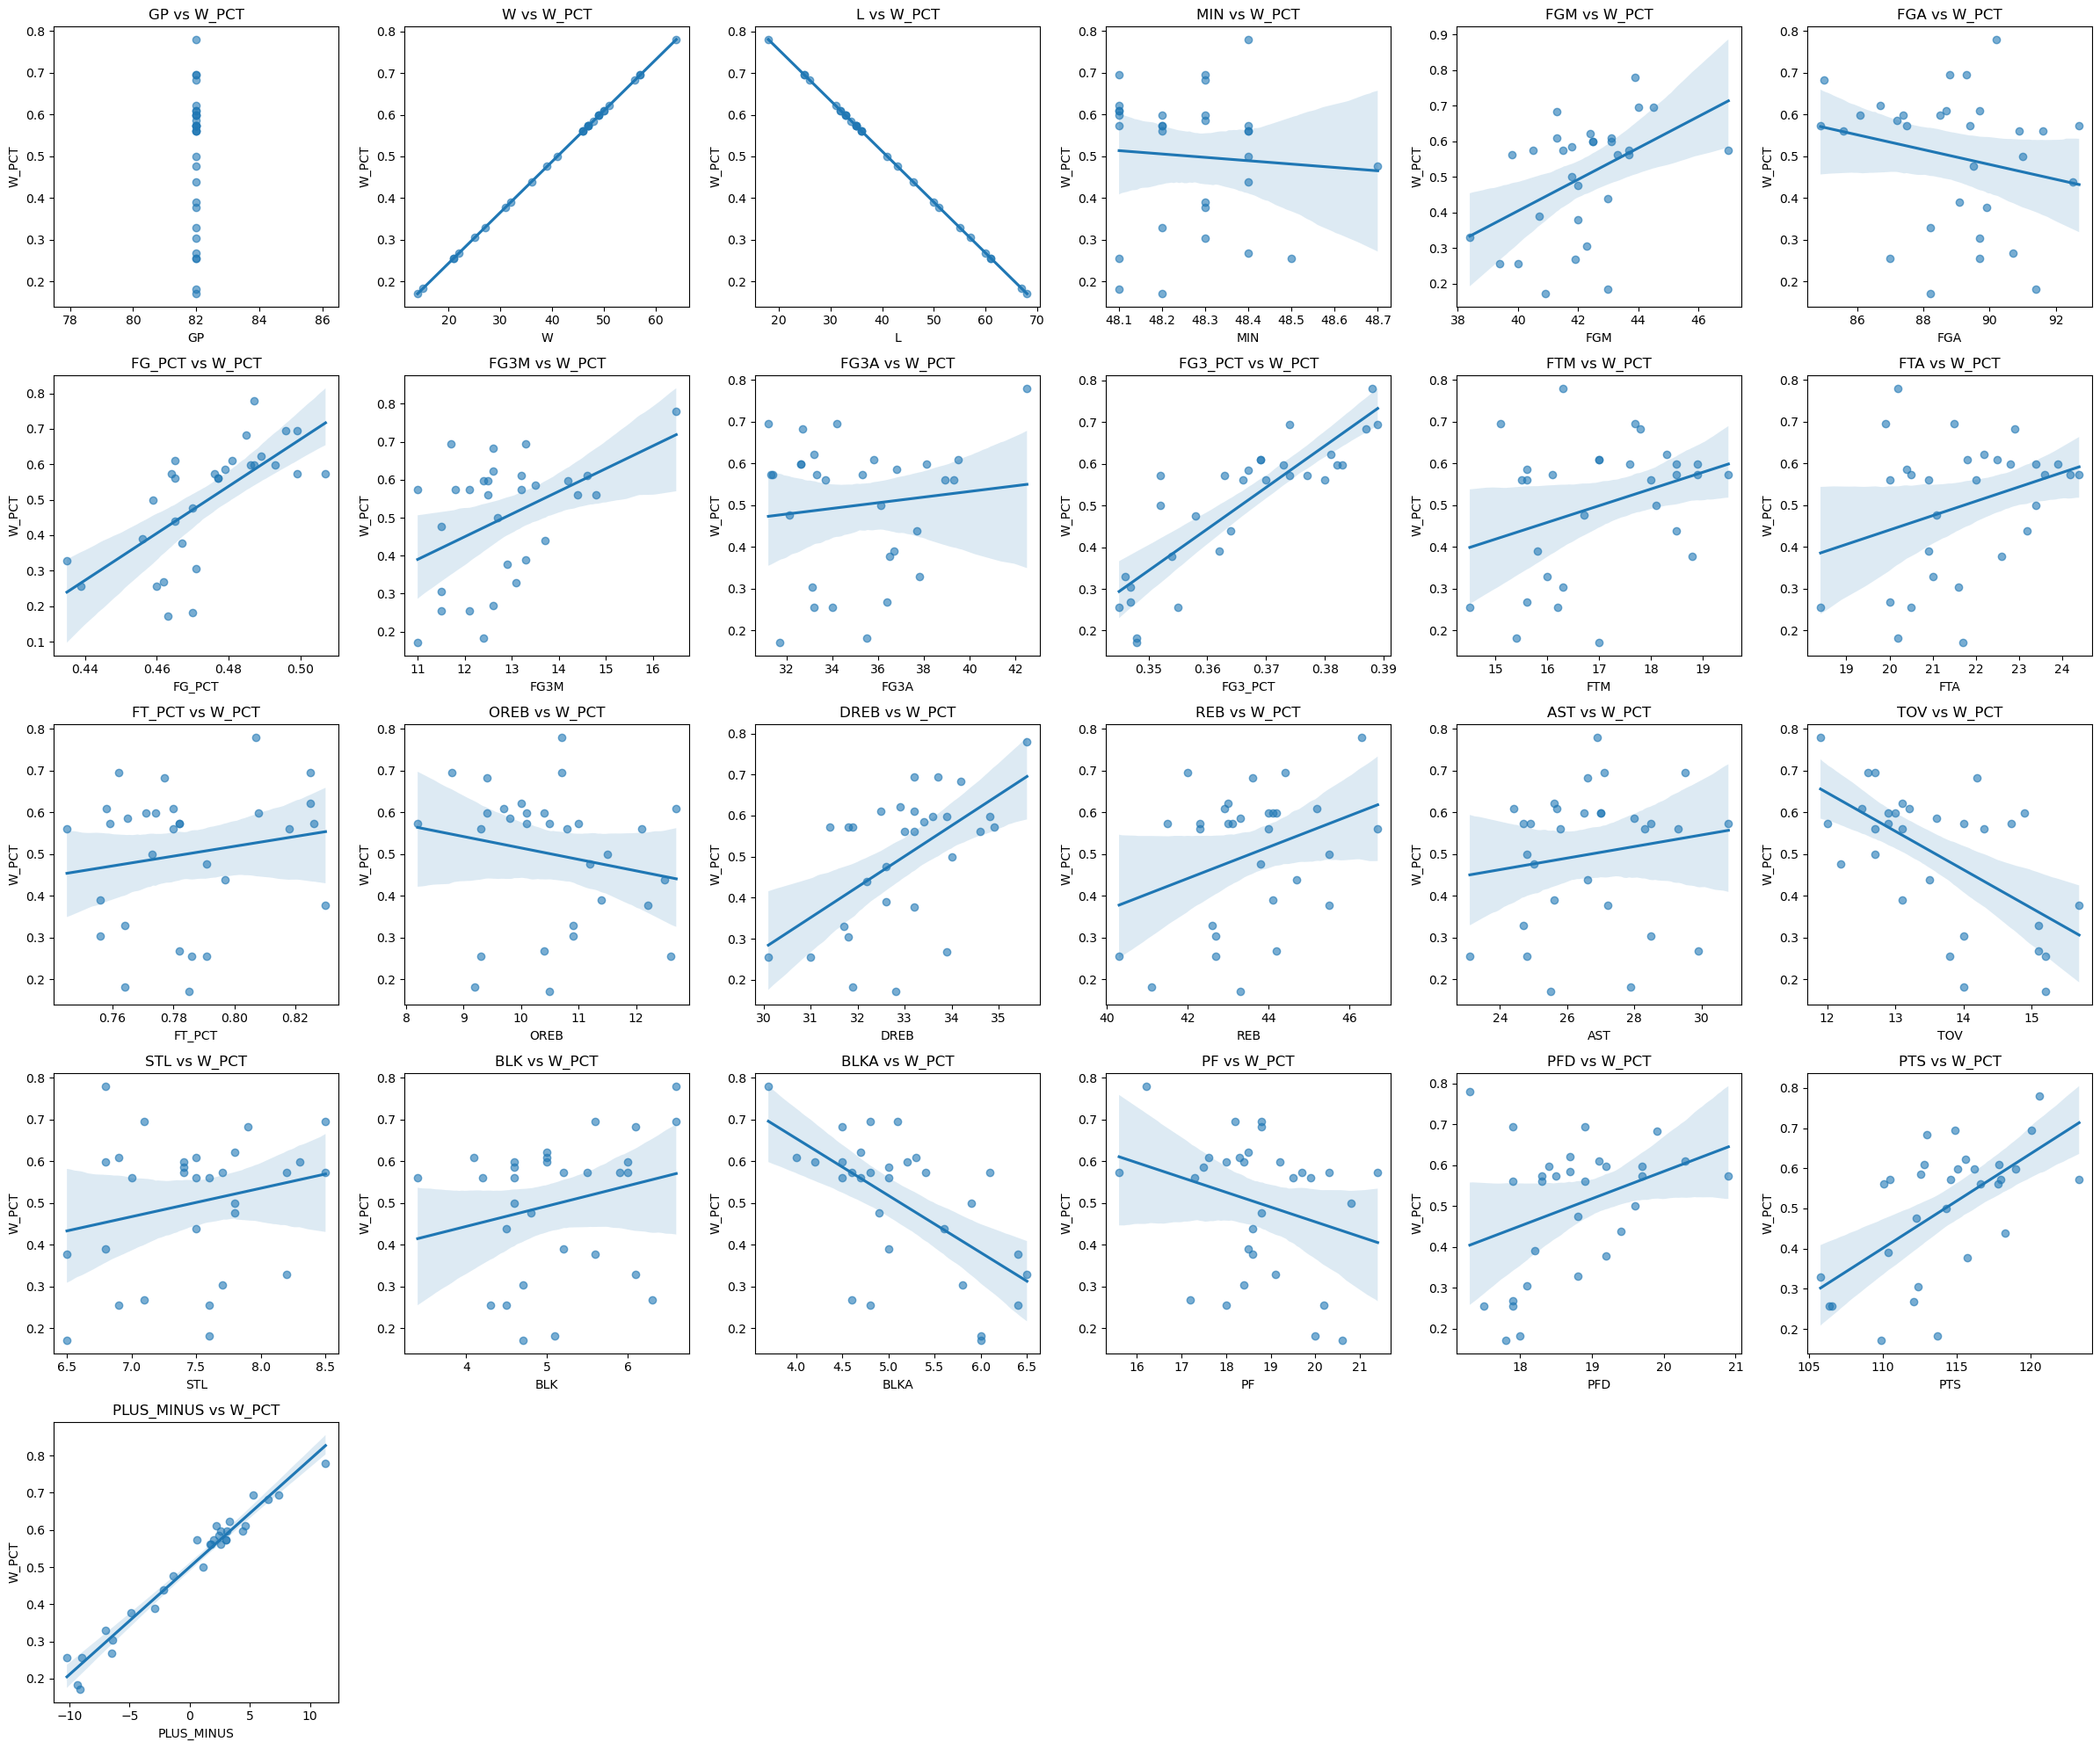

In [8]:
# Lista selittävistä muuttujista (NBA-numeraaliset)
features = [
    "GP", "W", "L", "MIN", "FGM", "FGA", "FG_PCT",
    "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT",
    "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK", "BLKA",
    "PF", "PFD", "PTS", "PLUS_MINUS"
]

# Määritellään grid 
n_cols = 6
n_rows = (len(features) + n_cols - 1) // n_cols  # pyöristetään ylöspäin

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()  # helpottaa indeksointia

for i, col in enumerate(features):
    sns.regplot(
        data=df,
        x=col,
        y="W_PCT",
        ax=axes[i],
        scatter_kws={"alpha":0.6}
    )
    axes[i].set_title(f"{col} vs W_PCT")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
corr = df.corr(numeric_only=True)
print(corr)

                  TEAM_ID  GP         W         L     W_PCT       MIN  \
TEAM_ID          1.000000 NaN -0.639333  0.639333 -0.639385 -0.225820   
GP                    NaN NaN       NaN       NaN       NaN       NaN   
W               -0.639333 NaN  1.000000 -1.000000  0.999999 -0.071924   
L                0.639333 NaN -1.000000  1.000000 -0.999999  0.071924   
W_PCT           -0.639385 NaN  0.999999 -0.999999  1.000000 -0.072068   
MIN             -0.225820 NaN -0.071924  0.071924 -0.072068  1.000000   
FGM             -0.297194 NaN  0.464400 -0.464400  0.464448 -0.034372   
FGA             -0.019551 NaN -0.225429  0.225429 -0.225658  0.280585   
FG_PCT          -0.337342 NaN  0.685370 -0.685370  0.685582 -0.210477   
FG3M            -0.387975 NaN  0.444940 -0.444940  0.444649  0.084246   
FG3A            -0.201927 NaN  0.119695 -0.119695  0.119297  0.150767   
FG3_PCT         -0.519182 NaN  0.855850 -0.855850  0.856018 -0.134123   
FTM             -0.170260 NaN  0.333783 -0.333783  

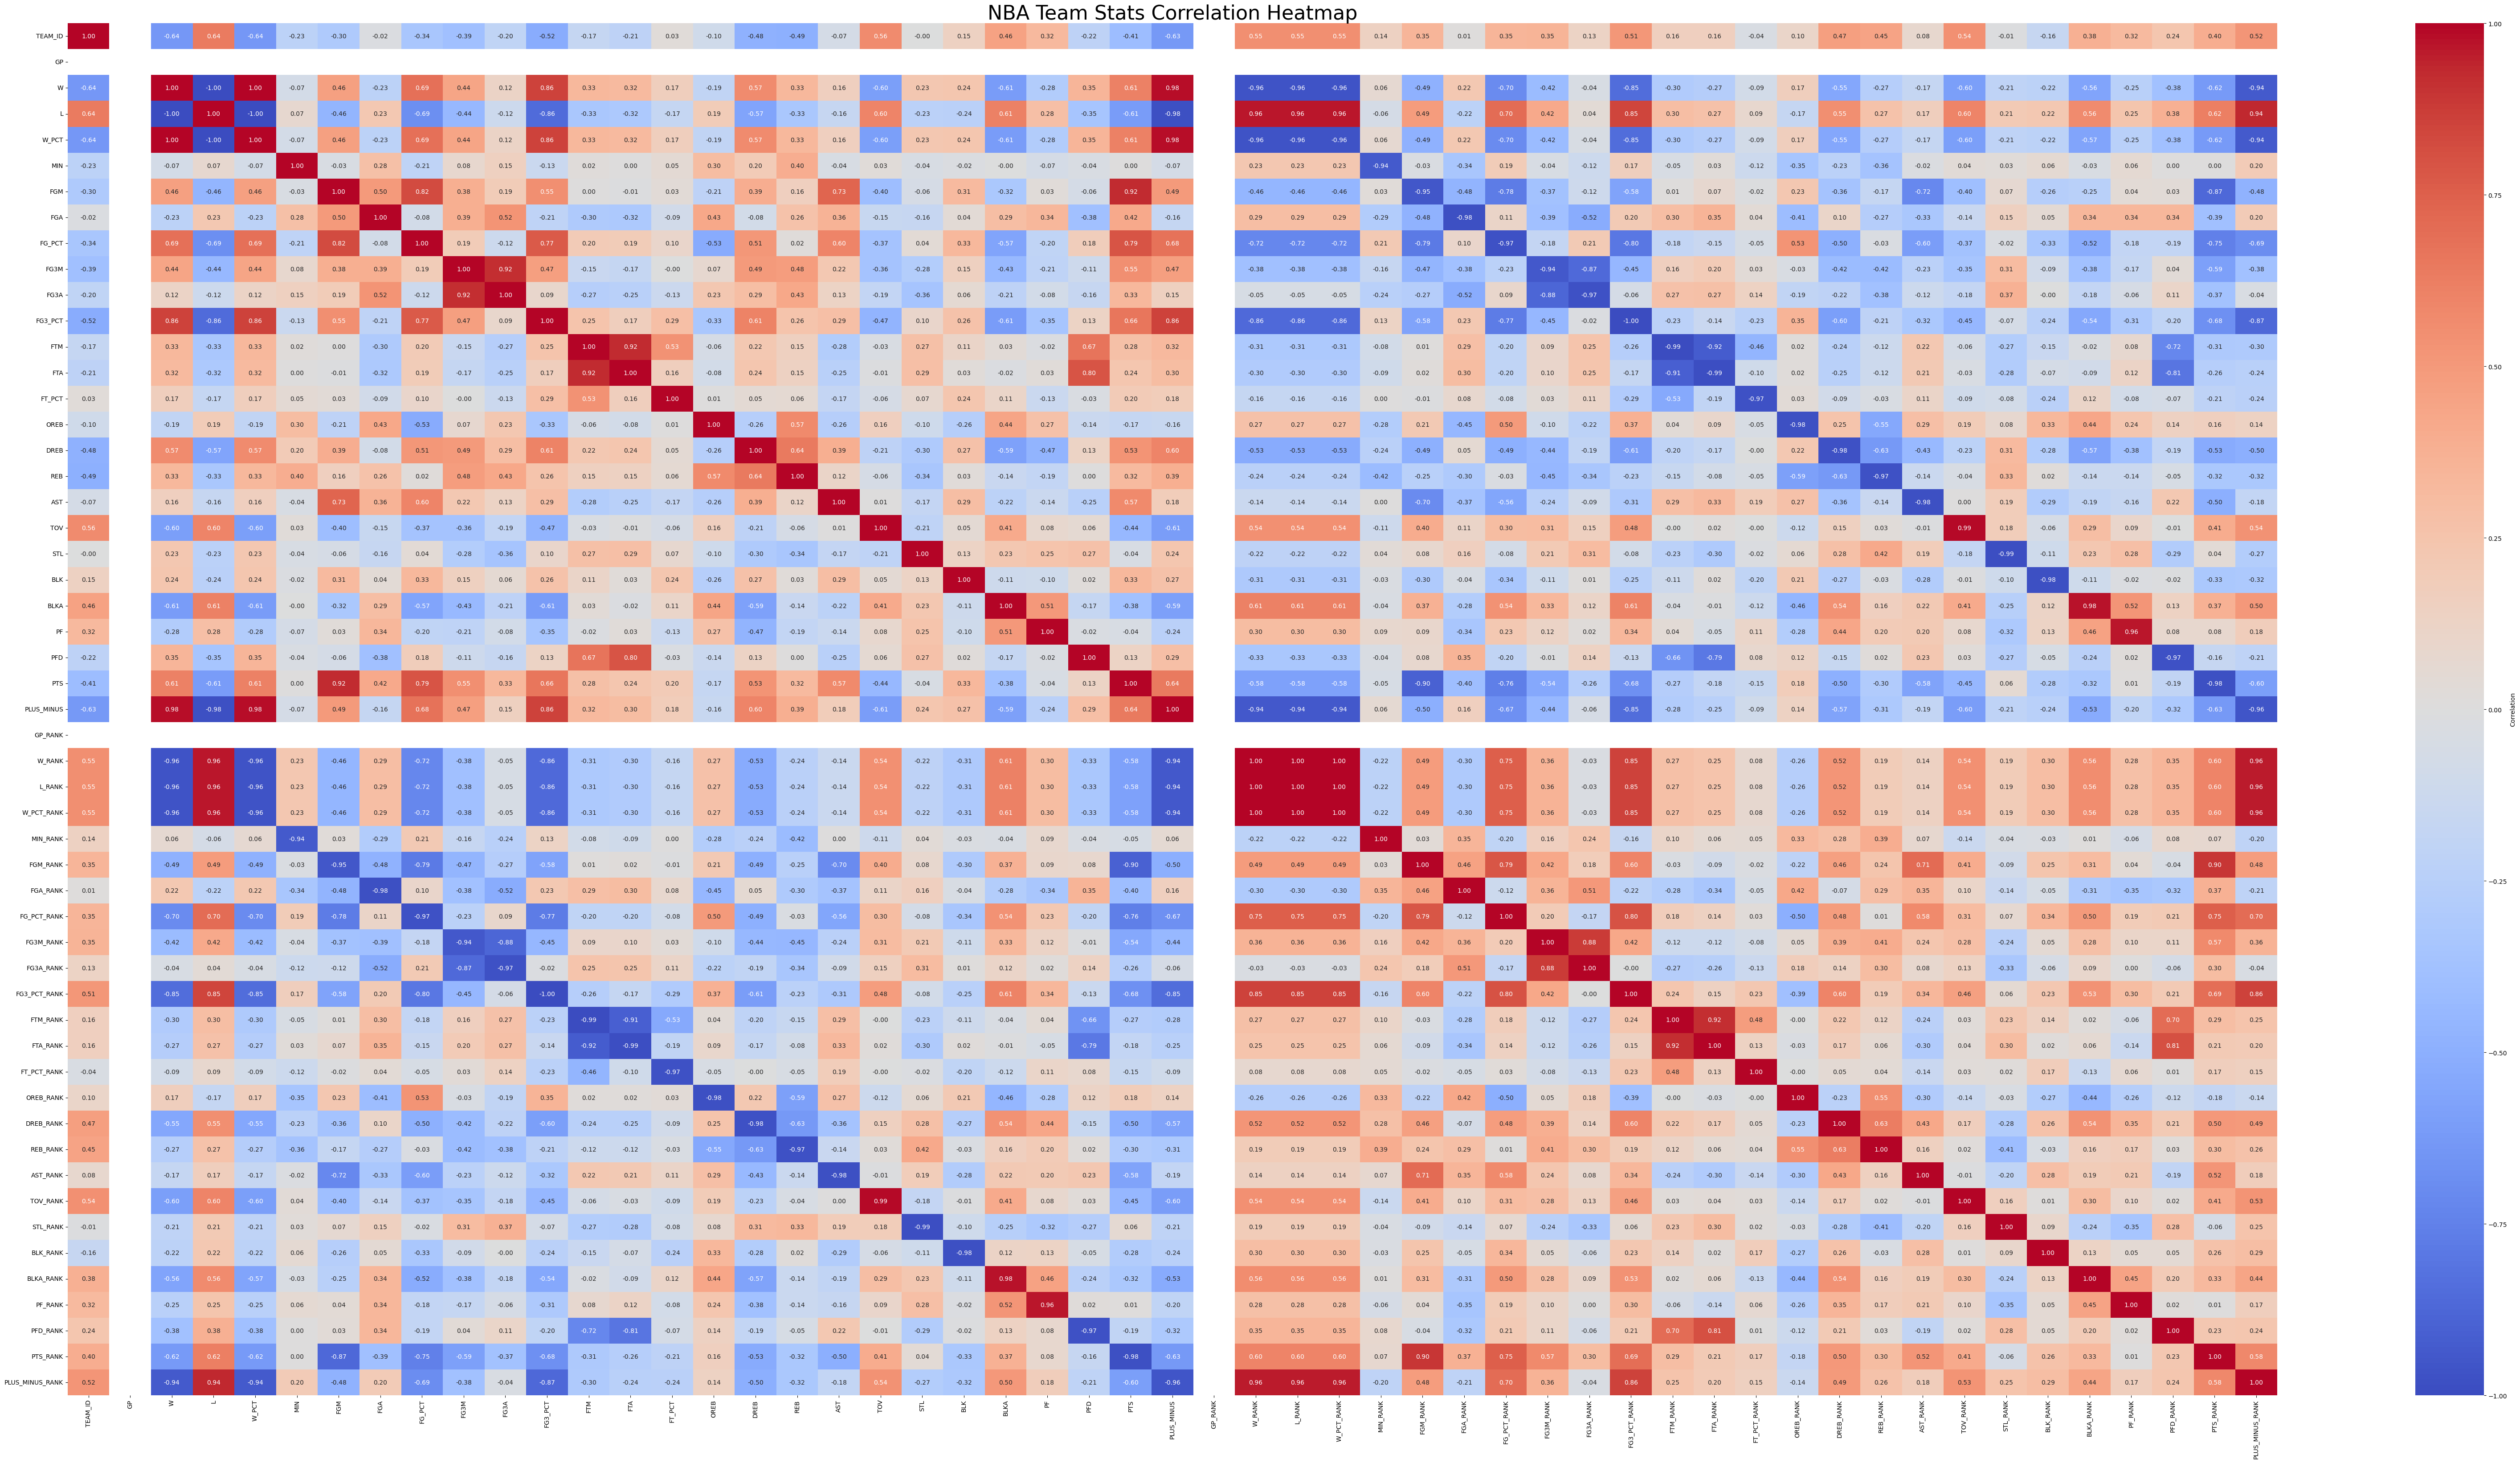

In [10]:
# Luodaan heatmap
plt.figure(figsize=(80, 40))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'label': 'Correlation'}
)
plt.title("NBA Team Stats Correlation Heatmap", fontsize=32)
plt.show()

# NBA-joukkueiden tilastojen korrelaatio voittoprosentin (W_PCT) kanssa

## Vahvat positiiviset korrelaatiot W_PCT:n kanssa

- **W (voitot): 0.9999**  
  Luonnollisesti voittoprosentti riippuu suoraan voittomäärästä.  

- **FG_PCT (Kenttäheittoprosentti): 0.685**  
  Joukkueet, joilla on korkeampi heittotarkkuus, voittavat yleensä enemmän.  

- **FG3_PCT (Kolmen pisteen prosentti): 0.856**  
  Tarkka kolmen pisteen heittäminen korreloi vahvasti voittojen kanssa.  

- **PTS (Pisteet per peli): 0.612**  
  Useamman pisteen tekeminen johtaa yleensä useampiin voittoihin.  

- **PLUS_MINUS: 0.982**  
  Piste-ero on vahva indikaattori joukkueen suorituskyvystä.  

- **DREB (Puolustavat levypallot): 0.566**  
  Puolustavat levypallot auttavat voittamaan pelejä.  

**Johtopäätös:** Hyökkäystehokkuus, kolmen pisteen heitot ja kokonaisvaltainen joukkueen suorituskyky ovat vahvoja ennustajia voitoille.

## Vahvat negatiiviset korrelaatiot W_PCT:n kanssa

- **L (tappiot): -0.9999**  
  Useampi tappio tarkoittaa luonnollisesti pienempää voittoprosenttia.  

- **TOV (Menetykset): -0.596**  
  Useammat pallonmenetykset vähentävät voittomahdollisuuksia.  

- Joidenkin **sijoitusperusteisten muuttujien** (esim. FG3A_RANK, W_RANK) negatiivinen korrelaatio johtuu siitä, että matala sijoitus tarkoittaa parempaa suorituskykyä.

## Kohtalaiset tai heikot korrelaatiot

- **MIN (Peliminuutit) ja AST (Syötöt)**  
  Näiden korrelaatio W_PCT:n kanssa on heikko; peliminuutit tai syötöt yksin eivät ennusta voittoja merkittävästi.  

- **FTA ja FTM (Vapaaheitot yrityksinä ja tehtyinä)**  
  Kohtalainen korrelaatio (~0.3); vapaaheitot vaikuttavat hieman, mutta eivät yhtä paljon kuin kenttäheitot.  

- **REB (Kokonaislevypallot)**  
  Puolustavat levypallot ovat tärkeämpiä kuin hyökkäävät.

## Tärkeimmät havainnot

**Parhaat lineaariset ennustajat W_PCT:lle:**  
1. PLUS_MINUS  
2. FG3_PCT  
3. FG_PCT  
4. PTS  
5. TOV (negatiivinen vaikutus)  

Useimmat **sijoitusperusteiset ominaisuudet** korreloivat hyvin, mutta ne on johdettu muista tilastoista eivätkä selitä voittoja itsenäisesti.

In [11]:
corr = df.corr(numeric_only=True)
corr["W_PCT"].sort_values(ascending=False)

W_PCT              1.000000
W                  0.999999
PLUS_MINUS         0.981516
FG3_PCT            0.856018
FG_PCT             0.685582
PTS                0.612193
DREB               0.566849
FGM                0.464448
FG3M               0.444649
PFD                0.349533
REB                0.334798
FTM                0.334222
FTA                0.315913
BLK                0.236602
STL                0.231151
FGA_RANK           0.223769
OREB_RANK          0.170308
FT_PCT             0.170029
AST                0.156954
FG3A               0.119297
MIN_RANK           0.063584
FG3A_RANK         -0.039924
MIN               -0.072068
FT_PCT_RANK       -0.085237
AST_RANK          -0.165684
OREB              -0.192848
STL_RANK          -0.205349
BLK_RANK          -0.220099
FGA               -0.225658
PF_RANK           -0.245724
REB_RANK          -0.265674
FTA_RANK          -0.272212
PF                -0.283380
FTM_RANK          -0.296880
PFD_RANK          -0.383162
FG3M_RANK         -0

In [27]:
X_train = df[[
    "FG_PCT",
    "FG3_PCT",
    "PTS",
    "DREB",
    "TOV",
    "PLUS_MINUS"
]]

y_train = df["W_PCT"]

X_test = test_df[[
    "FG_PCT",
    "FG3_PCT",
    "PTS",
    "DREB",
    "TOV",
    "PLUS_MINUS"
]]

y_test = test_df["W_PCT"]

# Ylimääräinen testisetti
X_test2 = test_df2[[
    "FG_PCT",
    "FG3_PCT",
    "PTS",
    "DREB",
    "TOV",
    "PLUS_MINUS"
]]

y_test2= test_df2 ["W_PCT"]

In [37]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_test2:", X_test2.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_test2:", y_test.shape)

X_train: (30, 6)
X_test: (30, 6)
X_test2: (30, 6)
y_train: (30,)
y_test: (30,)
y_test2: (30,)


In [32]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Arvioidaan ennuste
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Coefficient of Determination (R²): {r2:.3f}")

Mean Squared Error: 0.0012
Root Mean Squared Error: 0.034
Coefficient of Determination (R²): 0.955


In [33]:
# Ylimääräinen testi jossa ennustetaan vuoden 2022 - 2023 tuloksia seuraavan vuoden tuloksilla
y_pred2 = reg.predict(X_test2)

# Arvioidaan ennuste
mse2 = mean_squared_error(y_test2, y_pred2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(y_test2, y_pred2)

print(f"Mean Squared Error: {mse2:.4f}")
print(f"Root Mean Squared Error: {rmse2:.3f}")
print(f"Coefficient of Determination (R²): {r2_2:.3f}")

Mean Squared Error: 0.0016
Root Mean Squared Error: 0.040
Coefficient of Determination (R²): 0.892


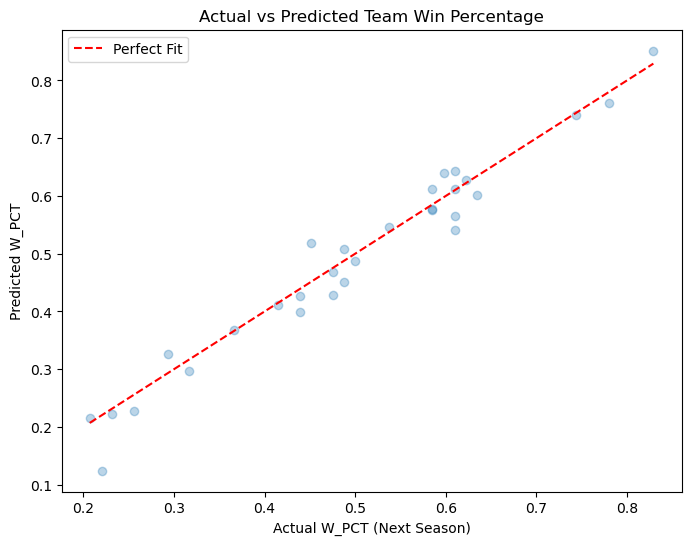

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual W_PCT (Next Season)")
plt.ylabel("Predicted W_PCT")
plt.title("Actual vs Predicted Team Win Percentage")
# Perfect fit line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.legend()
plt.show()

# Yhteenveto NBA W_PCT Lineaarisesta Regressiosta

**Malli:** Lineaarinen regressio

**Käytetyt ominaisuudet:** `FG_PCT`, `FG3_PCT`, `PTS`, `DREB`, `TOV`, `PLUS_MINUS`

**Opetusdata:** Edellisen kauden joukkueiden tilastot

**Testidata:** Seuraavan kauden W_PCT

## Suorituskykymittarit

| Mittari | Arvo | Tulkinta |
|---------|------|----------|
| Keskivirheen neliö (MSE) | 0.00 | Erittäin pieni keskimääräinen neliövirhe; malli ennustaa W_PCT:n erittäin lähelle todellisia arvoja |
| Neliöjuuri keskimääräisestä neliövirheestä (RMSE) | 0.03 | Ennuste poikkeaa keskimäärin ±3% todellisesta W_PCT:stä |
| Selitysaste (R²) | 0.955 | 95,5% seuraavan kauden W_PCT:n vaihtelusta selittyy edellisen kauden tilastojen avulla |

## Havainnot

- Valitut ominaisuudet ovat vahvoja ennustajia tulevalle suorituskyvylle.  
- Tilastot kuten `PLUS_MINUS` ja `PTS` korreloivat vahvasti joukkueen menestyksen kanssa ja ovat melko vakaita kaudesta toiseen.  
- Korkea R² on realistinen NBA-kontekstissa, koska joukkueiden suorituskyky on yleensä johdonmukaista kaudesta toiseen, mutta äkilliset pelaajasiirrot voivat heikentää ennusteen tarkkuutta.  
- Lineaarinen regressio tarjoaa yksinkertaisen mutta tehokkaan tavan ennustaa joukkueiden voittoprosentteja.


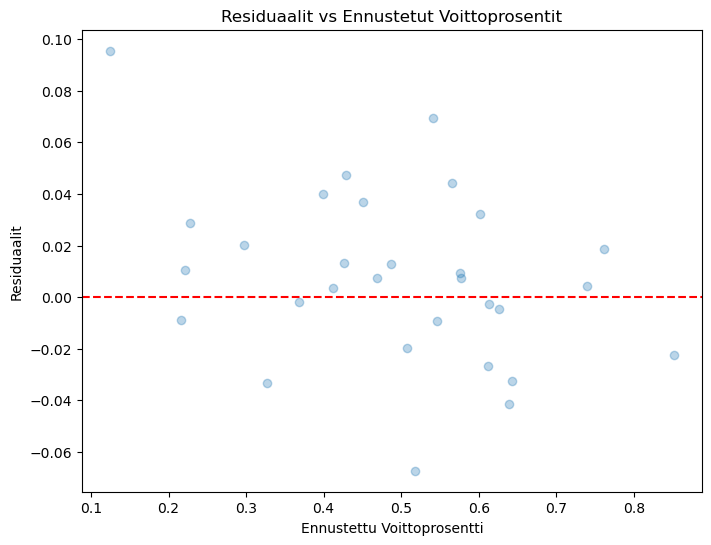

In [16]:
residuals = y_test - y_pred

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Ennustettu Voittoprosentti")
plt.ylabel("Residuaalit")
plt.title("Residuaalit vs Ennustetut Voittoprosentit")
plt.show()

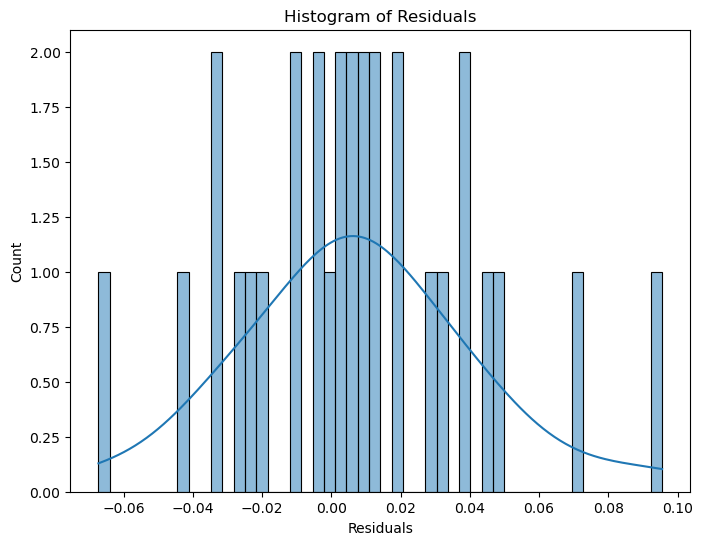

In [17]:
# Histogram of residuals (to check approximate normality)
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

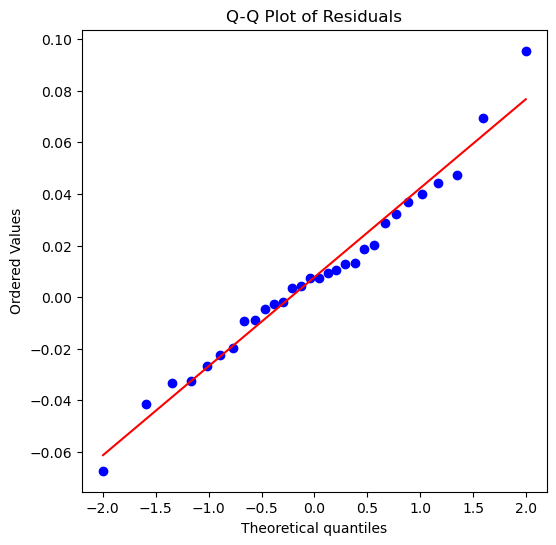

In [18]:
# Q-Q plot for normality check
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Lineaarisen Regression Oletukset – NBA W_PCT Analyysi

## Muuttujien tyypit (väli/luokittelu, jatkuva tavoite)

Kaikki numeeriset ennustajat FG_PCT, FG3_PCT, PTS, DREB, TOV, PLUS_MINUS ovat välimatka-muuttujia  
Kohde W_PCT on jatkuva  
Oletus suurin piirtein toteutuu

## Nollasta poikkeava vaihtelu

Kaikki ennustajat vaihtelevat joukkueiden välillä; ei vakio-sarakkeita  
Toteutuu

## Ei täydellistä multikollineaarisuutta

Jotkin muuttujat korreloivat keskenään (esim PTS ja PLUS_MINUS), mutta täydellistä multikollineaarisuutta ei ole  
Kohtalainen multikollineaarisuus voi kasvattaa kertoimien virheiden hajontaa

## Nollahajonnan virhe

Jäännösten keskiarvo tulisi olla noin nolla  
Ennustetun ja todellisen W_PCT:n hajontakuvio näyttää keskittyvän likimain nollan ympärille  
Todennäköisesti toteutuu, pieniä poikkeamia voi esiintyä

## Ennustajien ja virheiden korrelaation puuttuminen

Mahdollinen jätettyjen muuttujien vaikutus (esim pelaajasiirrot, loukkaantumiset, valmentaja)  
Ei täysin taattavissa

## Homoskedastisuus (vakio virhevariance)

Jäännösten ja ennusteiden hajontakuvio saattaa hieman kasvaa äärimmäisillä W_PCT-arvoilla joka merkitsee lievää heteroskedastisuutta  
Tilastollisiin johtopäätöksiin voi vaikuttaa, mutta kertoimet pysyvät puolueettomina

## Havainnoiden riippumattomuus

Jokainen rivi kuvaa joukkueen kautta  
Todennäköisesti riippumattomia  
Oletus suurin piirtein toteutuu

## Virheiden normaalijakauma

Pienessä aineistossa (n~73) normaalisuus on toivottavaa, mutta ei kriittistä ennusteiden kannalta  
Vähemmän kriittinen estimoinnissa, tärkeämpi hypoteesitestauksessa

## Yhteenveto

Suurin osa perusoletuksista toteutuu NBA-joukkueiden W_PCT:n ennustamisessa  

***Päähuomiot***  
Kohtalainen multikollineaarisuus piste- ja tehokkuustilastoissa  
Lievä heteroskedastisuus jäännöksissä  
Mahdolliset puuttuvat muuttujat (pelaajasiirrot, loukkaantumiset) voivat vaikuttaa virheisiin  

# 📊 NBA W_PCT Lineaarinen regressiomalli – arviointi eri kausilla

## Mallin asetelma
**Opetusdata:** Kausi 2023–24 (joukkueiden tilastot)  
**Testidata:**  
- **Eteenpäin ennustus:** Kausi 2024–25  
- **Taaksepäin testaus:** Kausi 2022–23  

---

## Suorituskykymittarit

| Testikausi | Mean Squared Error (MSE) | Root Mean Squared Error (RMSE) | R² (selitysaste) |
|-------------|--------------------------|--------------------------------|------------------|
| **2024–25 (seuraava kausi)** | 0.0012 | 0.034 | 0.955 |
| **2022–23 (edellinen kausi)** | 0.0016 | 0.040 | 0.892 |

---

## Tulosten tulkinta

### 1. Erinomainen ennustetarkkuus tulevalle kaudelle
Malli ennustaa seuraavan kauden voittoprosentin (W_PCT) erittäin tarkasti (R² = 0.955).  
Tämä viittaa siihen, että joukkueiden suorituskykytilastot ovat varsin pysyviä kaudesta toiseen, erityisesti heittotarkkuuden ja piste-eron osalta.

### 2. Heikompi tarkkuus menneeseen kauteen ennustettaessa
Kun mallia testataan edellisen kauden tiedoilla, suorituskyky laskee hieman (R² = 0.892).  
Tämä on loogista, koska malli perustuu tulevaisuuden tietoihin, joissa näkyvät jo pelaajamuutokset ja pelitaktiikan kehitys**, joita menneellä kaudella ei ollut.

### 3. Mallin vakaus ajan yli
Pieni ero selitysasteissa (0.955 vs. 0.892) kertoo, että tilastolliset suhteet (esim. FG_PCT, FG3_PCT, PLUS_MINUS) ovat pysyneet rakenteellisesti samoina eri kausilla.  
Malli näyttää siis oppivan kestävän ja kausien yli toimivan suhteen suorituskykymuuttujien ja voittoprosentin välillä.

---

## Yhteenveto
- Malli on vakaa ja ajallisesti luotettava.  
- Eteenpäin ennustaminen (2024–25) onnistuu erittäin hyvin ja antaa realistisia tuloksia.  
- Taaksepäin ennustaminen (2022–23) on hieman heikompaa, mutta yhä käyttökelpoista.  
- Lineaarinen regressio osoittautuu yllättävän tehokkaaksi menetelmäksi NBA-joukkueiden voittoprosentin ennustamiseen.